In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Image
import pandas as pd
#from basics_functions import cena_dzielnica, cena_oferta, gdzie_najdrozej, rozklad_ofert, klastry_dzielnice
from functions import formularz, click_button_moj, xgboost_check, xgboost_model, xgboost_calosc, oblicz_cene, click_button_model
import functools
from ipywidgets import Layout
import folium
from data_preparation import drawAllHist, drawAllBoxplot, corrHeatmap
from diagrams import plot_available_price
from RF_function import RandomForest_model

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [22]:
# Datasety
data_prep_1_drop = pd.read_csv('../data/data_prep_1_drop.csv')
subplots_histograms = pd.read_csv('../data/subplots_histograms.csv')
subplots_Boxplots = pd.read_csv('../data/subplots_Boxplots.csv')
corr = pd.read_csv('../data/data_prep_corr.csv')
dummies_var = pd.read_csv('../data/data_prep_2_drop.csv')

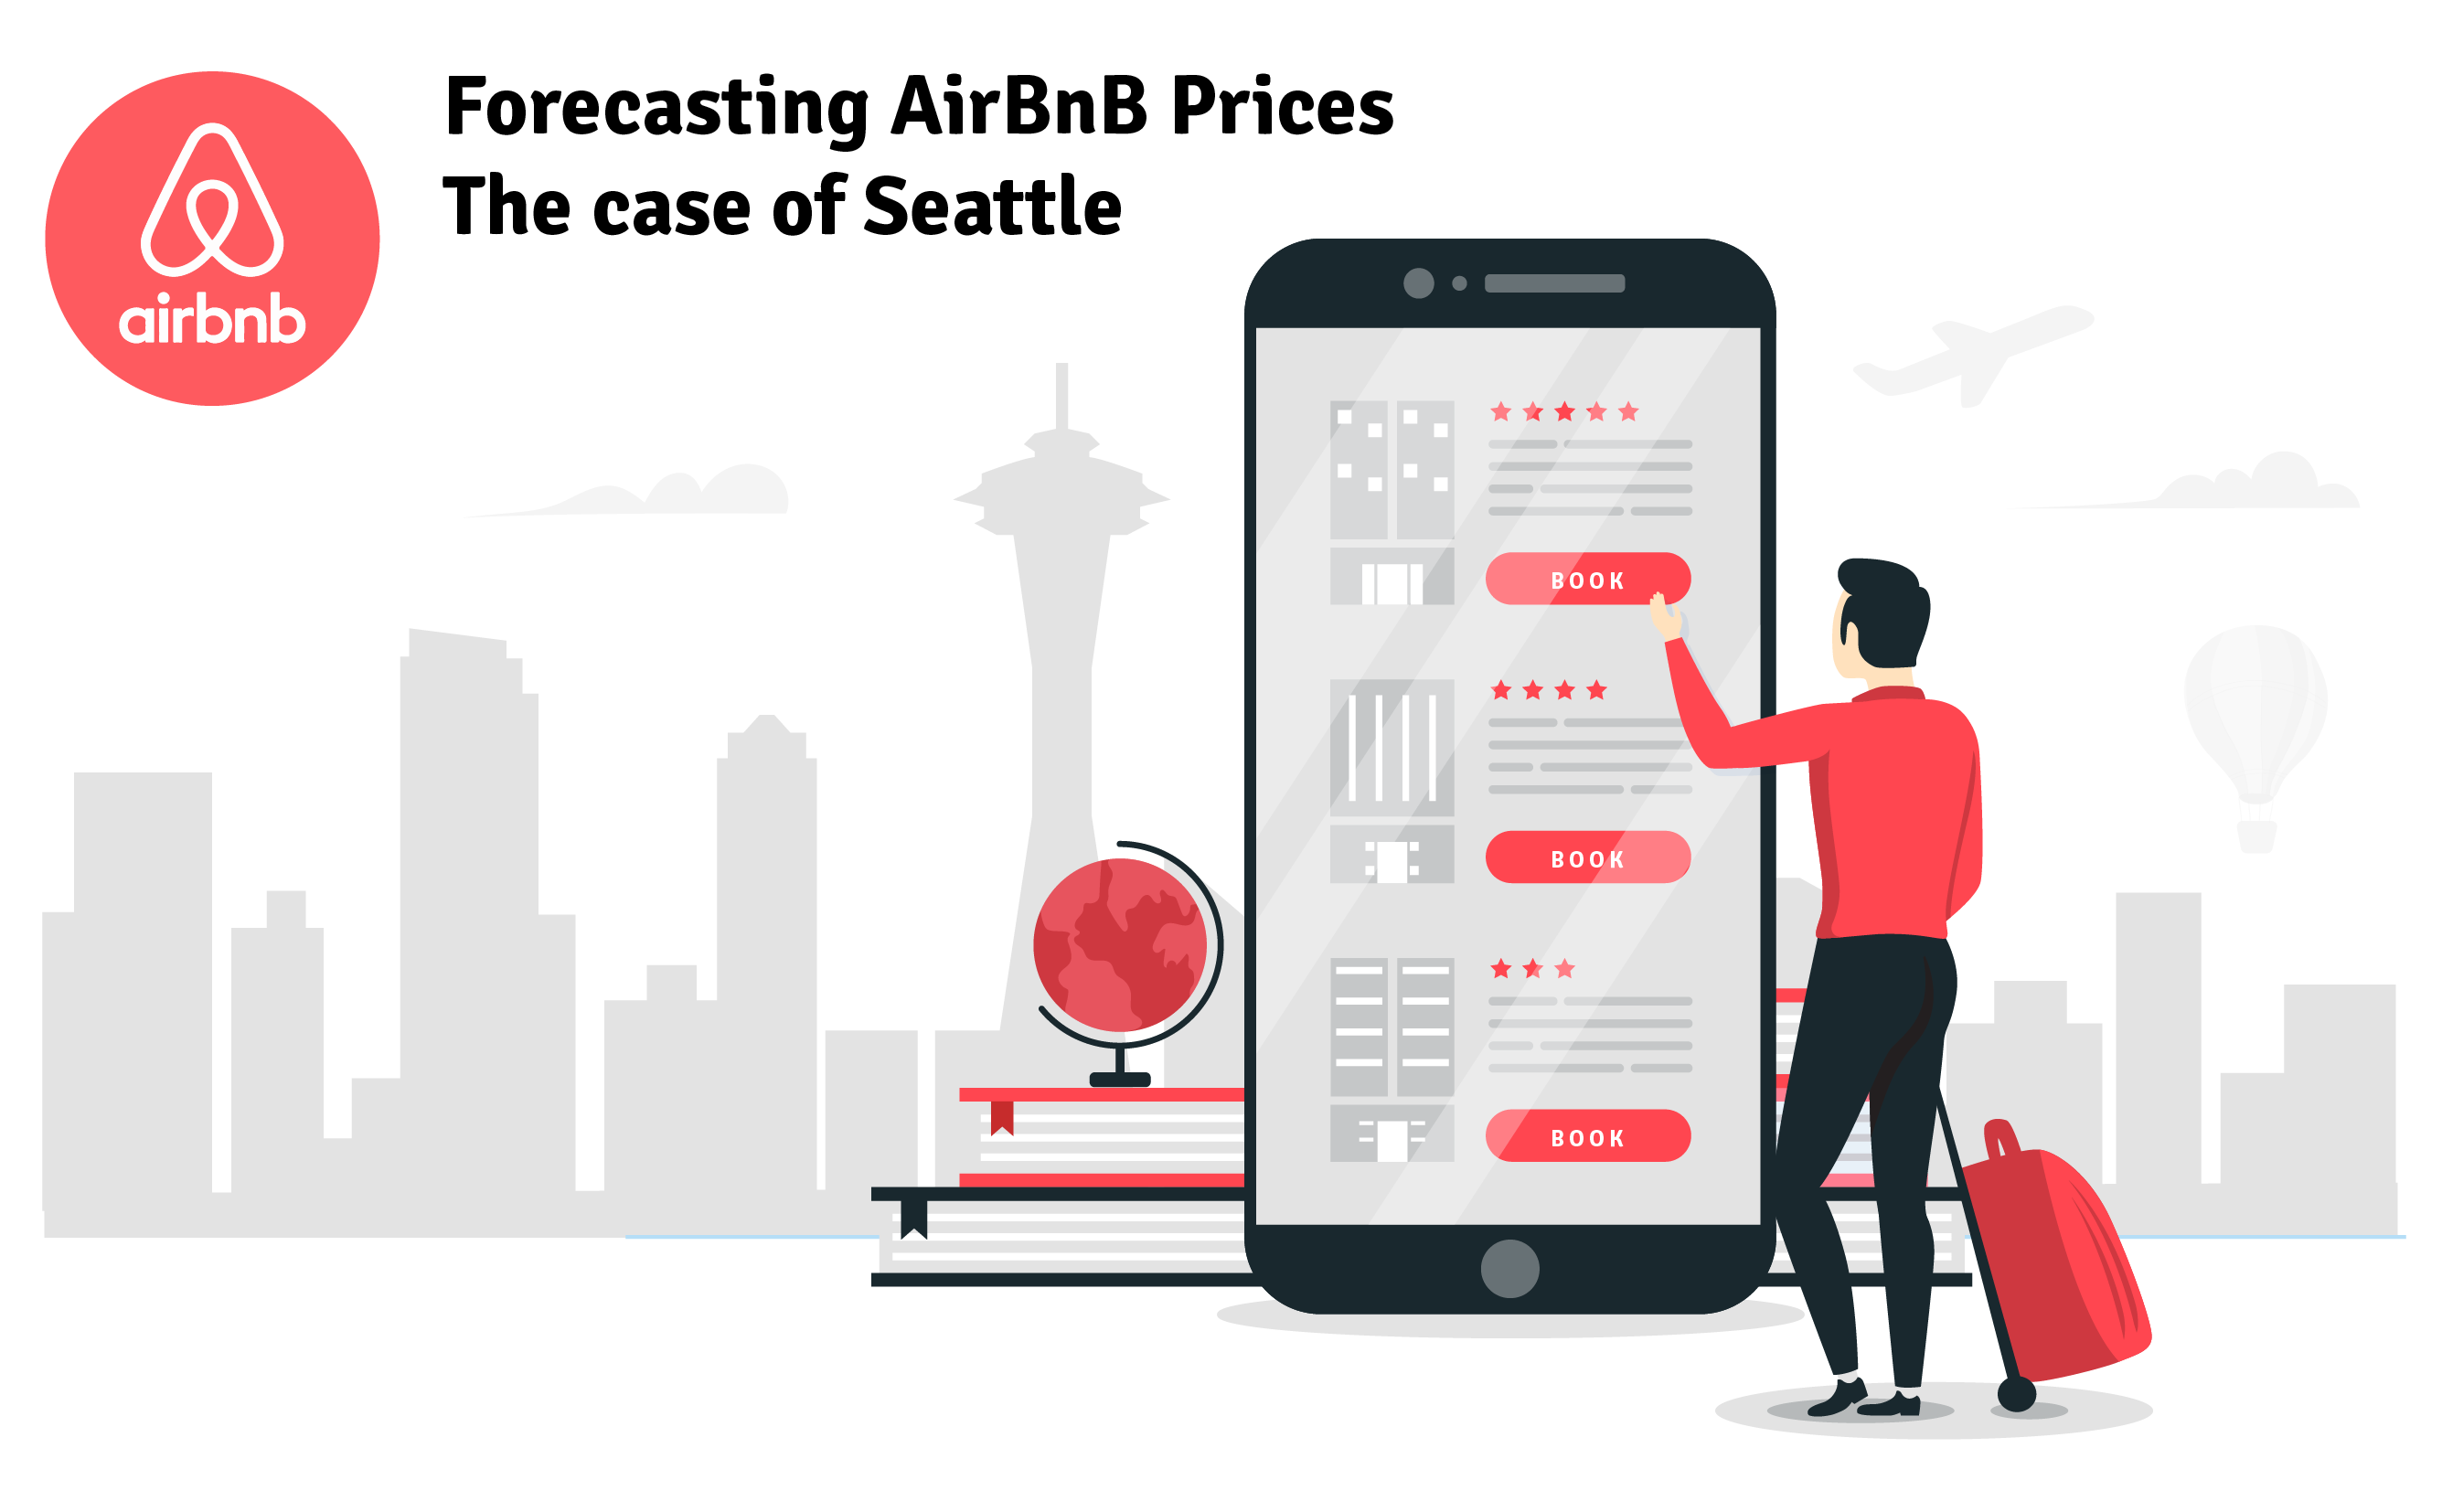

In [3]:
display(Image(filename='../graphics/app/airbnb-02.png'))

## <span style="color:#ff4650"> Etapy projektu:</span>
### 1. Określenie problemu, celu projektu i przeanalizowanie do w szerszej perspektywie.
### 2. Analiza danych w celu uzyskania informacji o badanym zbiorze.
### 3. Selekcja i przygotowanie danych pod kątem algorytmów Machine Learning.
### 4. Sprawdzenie i konfiguracja hiperparametrów wybranych algorytmów.
### 5. Zaprezentowanie najlepszego modelu.
### 6. Prezentacja aplikacji wykorzystującej wybrany model.

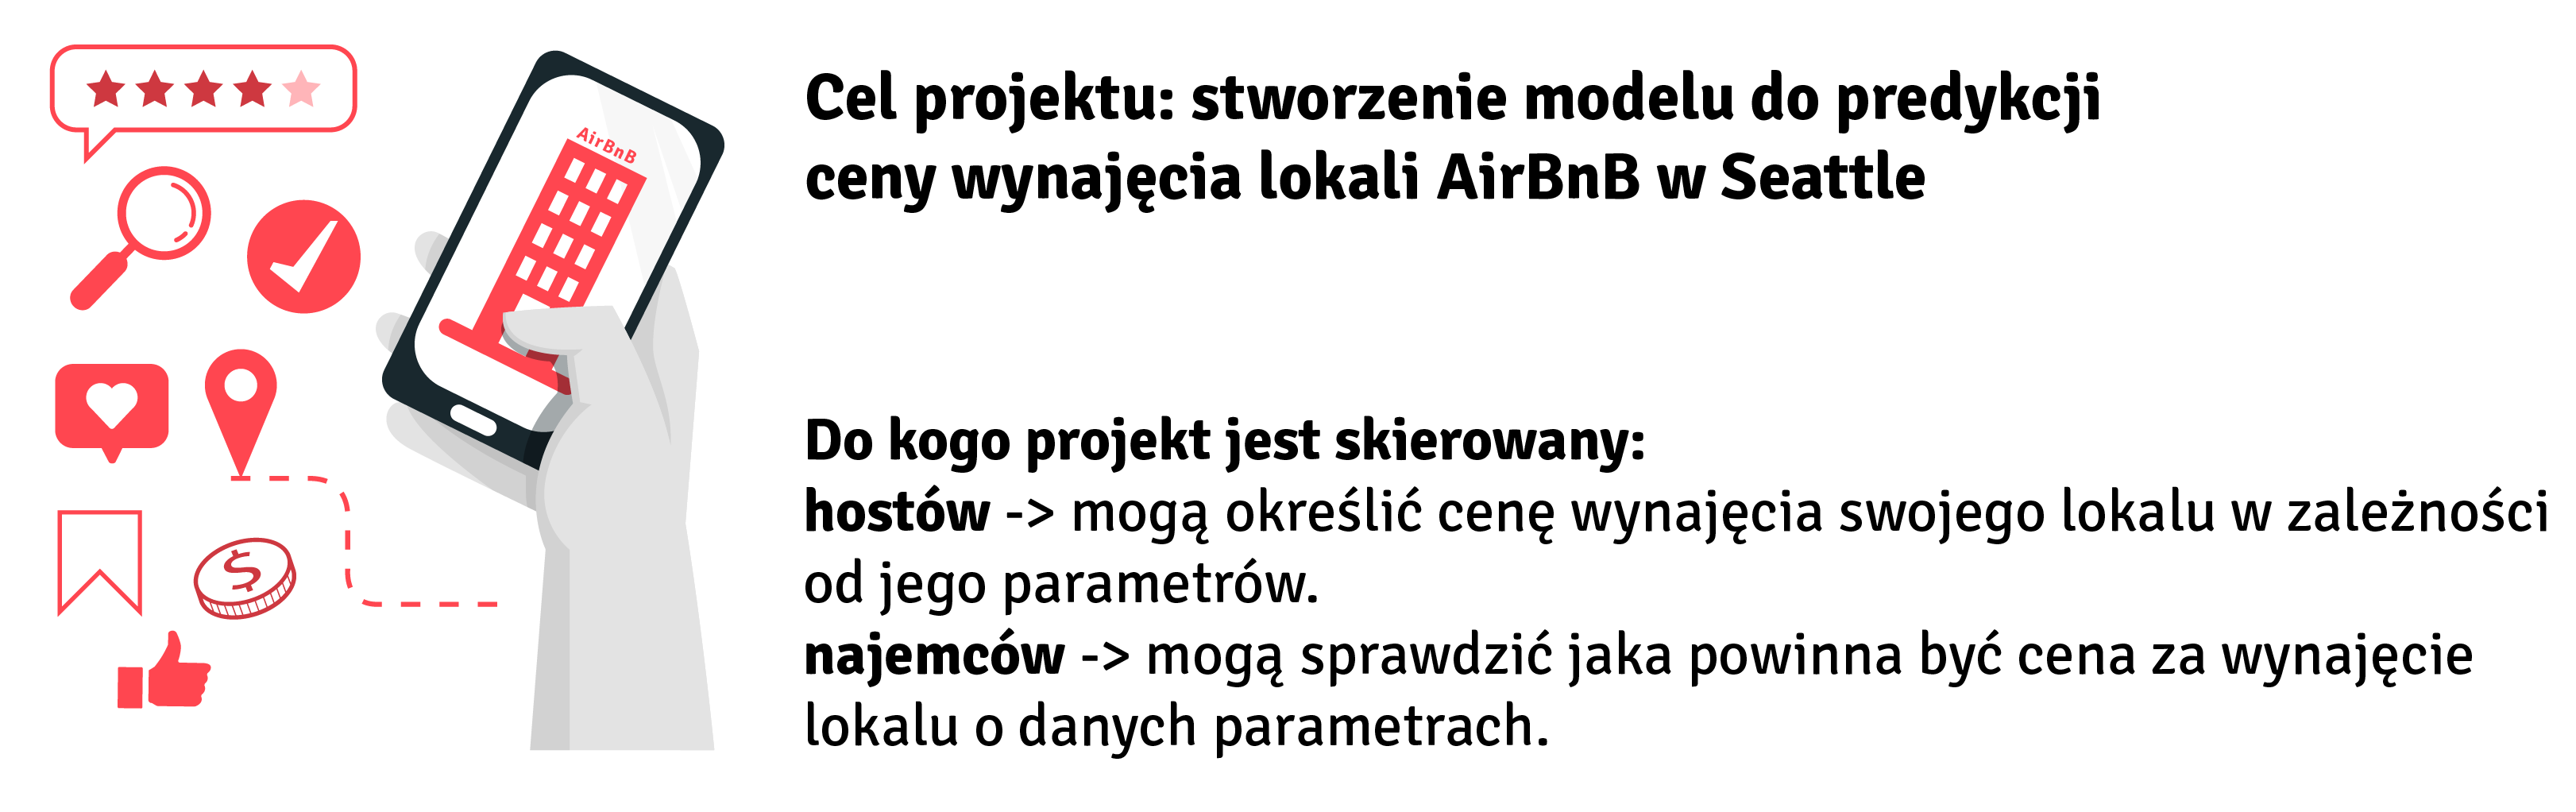

In [4]:
display(Image(filename='../graphics/app/airbnb-03.png'))

## <span style="color:#ff4650"> Charakterystyka projektu:</span>
### - Źródło danych: https://www.kaggle.com/airbnb/seattle
### - Rozmiar bazy danych:  86 MB, listings.csv (92 kol., 3818 wier.). calendar.csv (4 kol,1393569 wier.).
### - Uczenie nadzorowane.
### - Uczenie wsadowe.
### - Regresja z wieloma zmiennymi.
### - Metryki wydajności: RMSE, MAE.
### - Minimalna wydajność wymagana do spełnienia celu biznesowego: MAE = 10.
### - Docelowy atrybut: price.

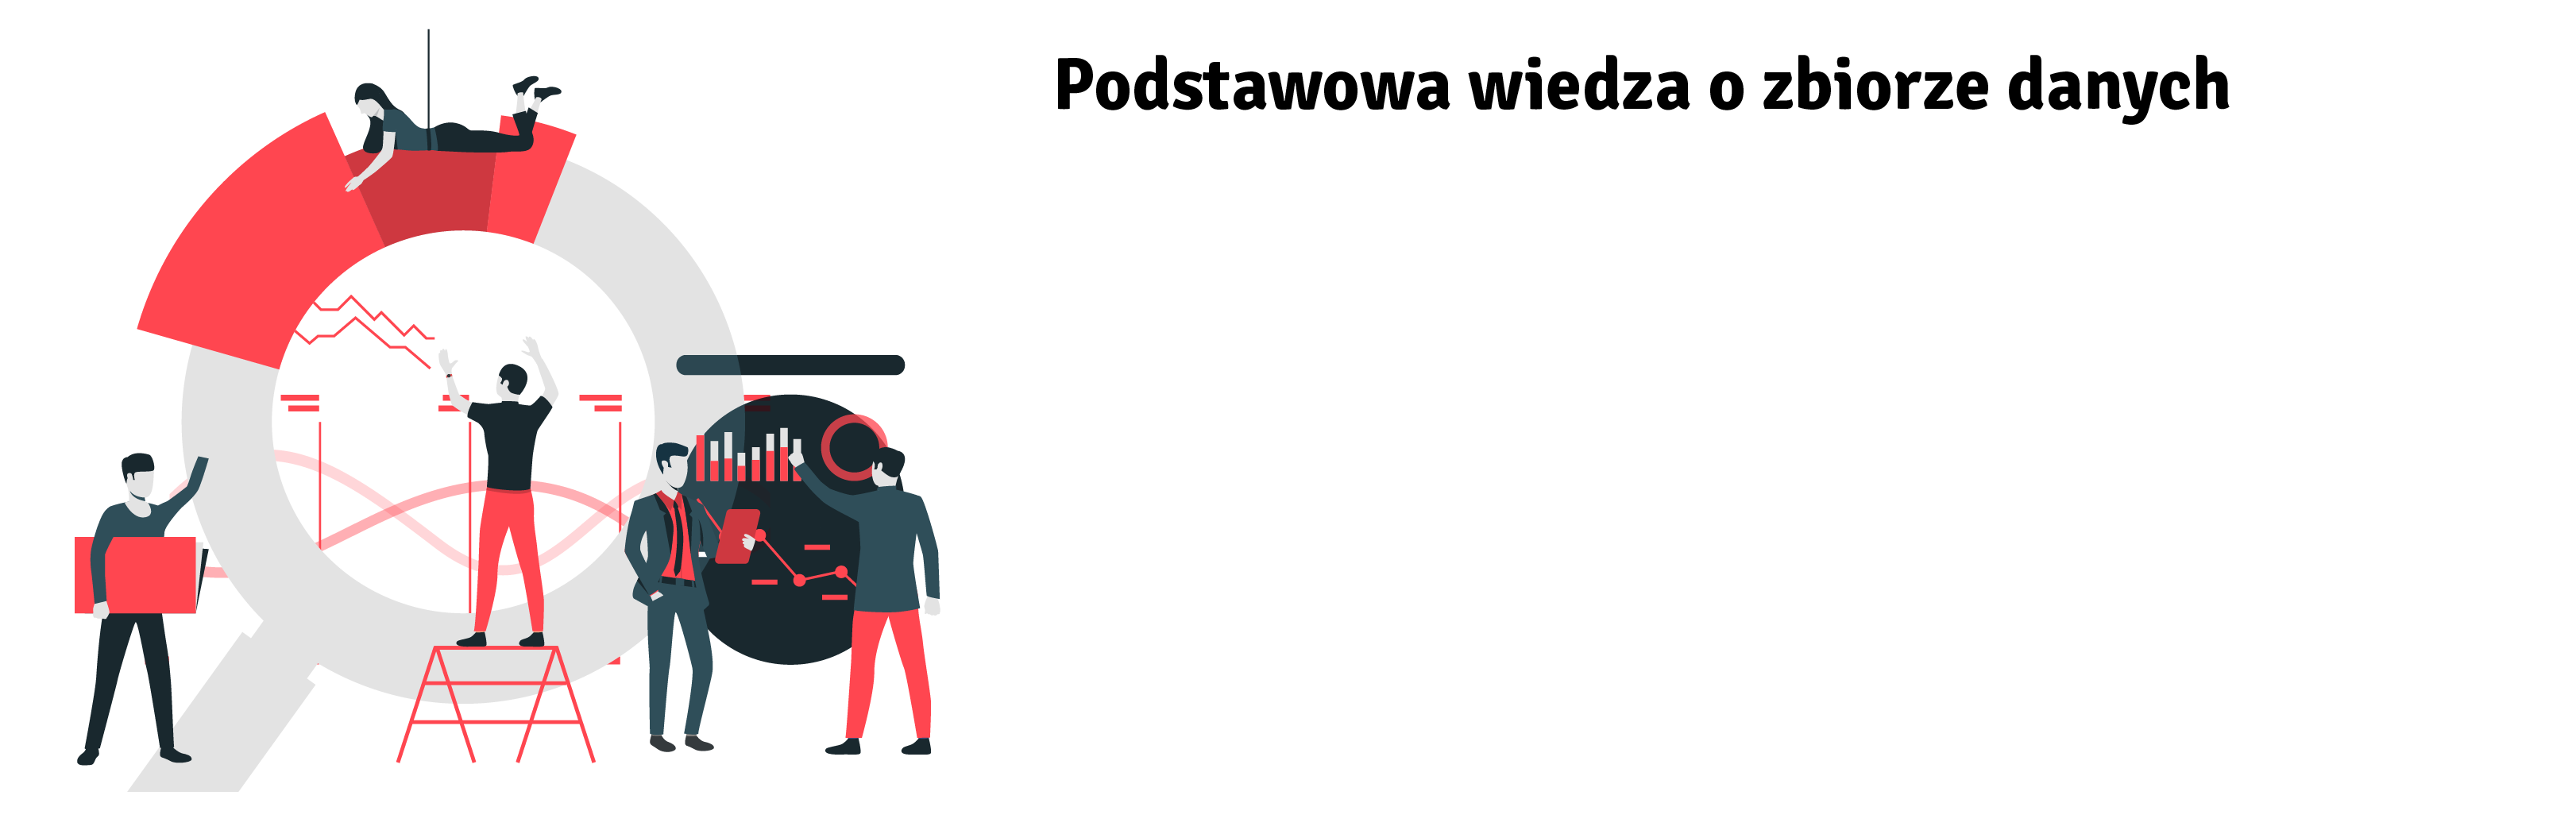

In [5]:
display(Image(filename='../graphics/app/airbnb-06.png'))

### Oryginalny dataset

In [6]:
df_orig = pd.read_csv('../data/listings.csv')

In [7]:
calendar = pd.read_csv('../data/calendar.csv',parse_dates=['date'])

### Zmienne

In [8]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [9]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  object        
 3   price       934542 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB


In [10]:
df_orig.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [11]:
calendar.head(3)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN


## <span style="color:#ff4650"> Przygotowanie danych</span>

### 1. Wstępne usunięcie zbędnych kolumn (opisy tekstowe, brak danych, nieistotne dane).
### 2. Poprawienie formatu zmiennych (np. usunięcie symbolu waluty, zmiana typu danych).
### 3. Uzupełnienie lub usunięcie brakujących wartości.

In [12]:
nan_count = round(data_prep_1_drop.isnull().mean(),3)
nan_count

id                      0.000
host_is_superhost       0.000
zipcode                 0.002
property_type           0.000
room_type               0.000
accommodates            0.000
bathrooms               0.004
bedrooms                0.002
beds                    0.000
bed_type                0.000
price                   0.000
security_deposit        0.511
cleaning_fee            0.270
guests_included         0.000
extra_people            0.000
minimum_nights          0.000
maximum_nights          0.000
number_of_reviews       0.000
review_scores_rating    0.169
cancellation_policy     0.000
host_experience         0.001
dtype: float64

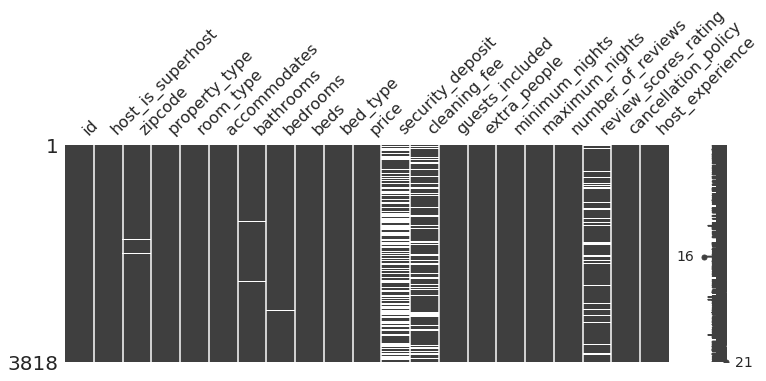

In [13]:
msno.matrix(data_prep_1_drop, figsize=(12,4))
pass

### 4. Histogramy zmiennych.

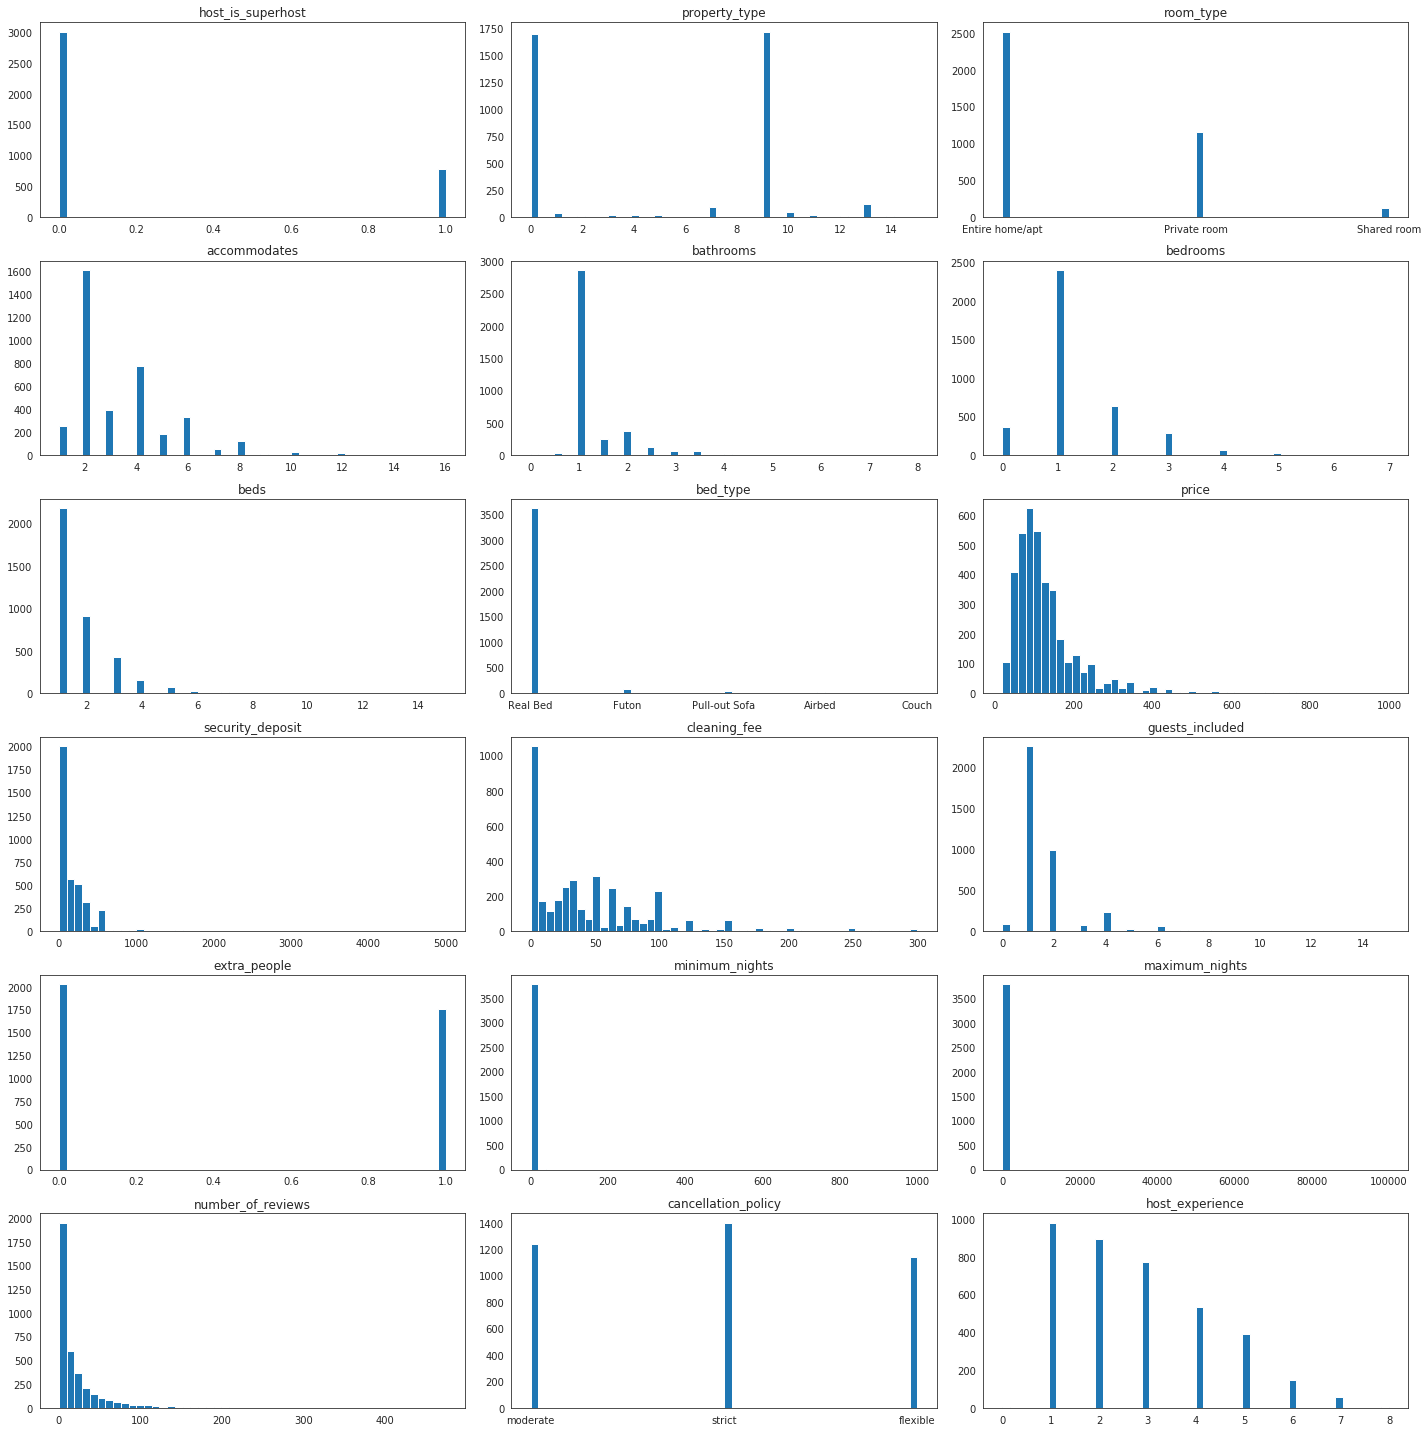

In [14]:
drawAllHist(subplots_histograms, 3,50)

### 5. Boxploty zmiennych.

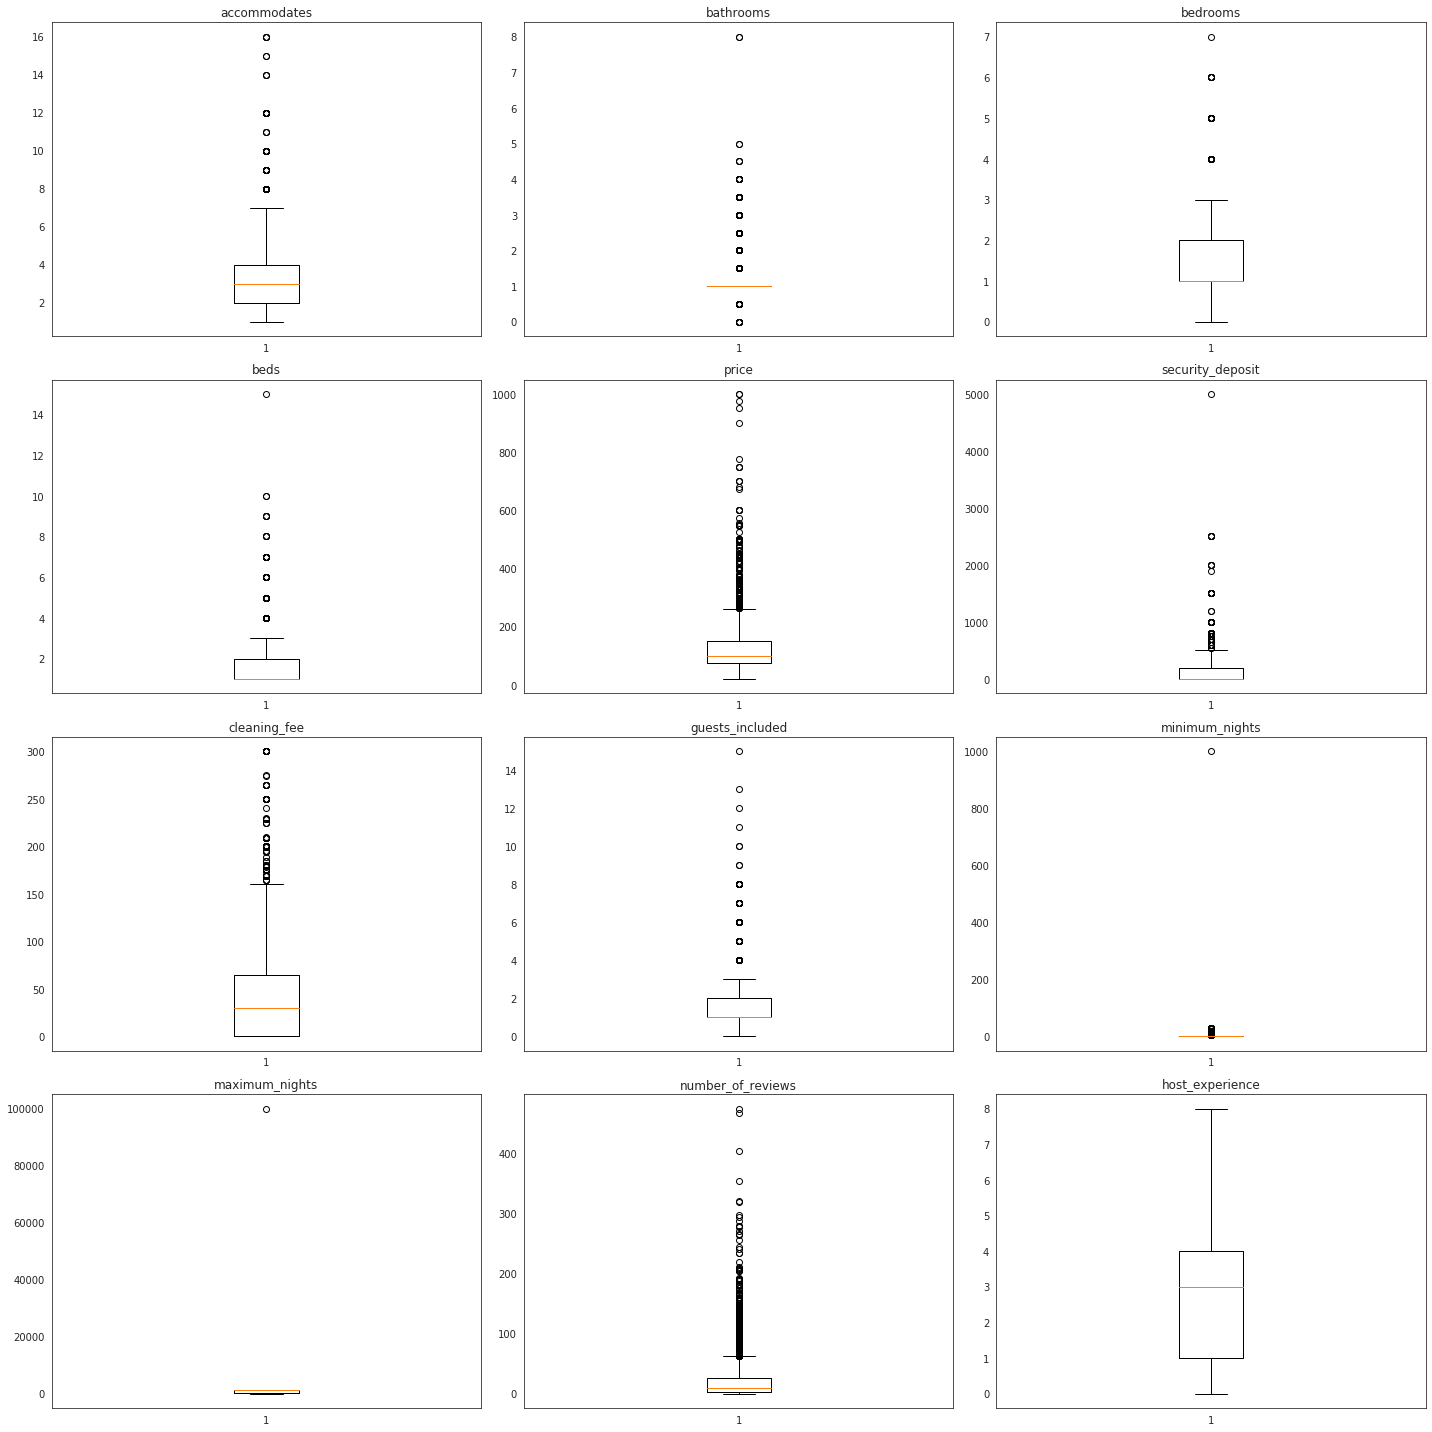

In [15]:
drawAllBoxplot(subplots_Boxplots, 3)

### 6. Usunięcie wartości odstających (q1 - 1.5 * IQR, q3 + 1.5 * IQR).

### 7. Korelacje zmiennych i selekcja zmiennych.

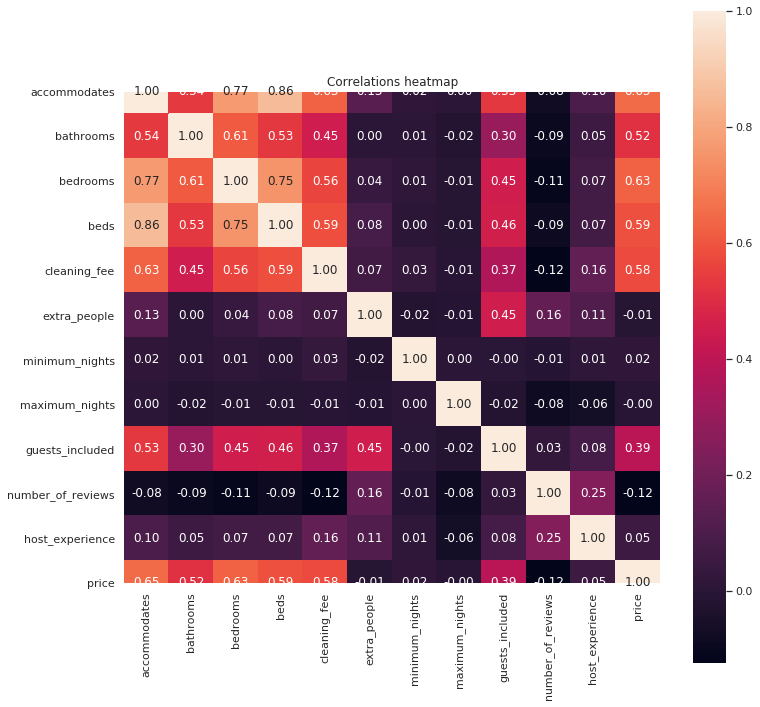

In [16]:
cols = ['accommodates','bathrooms','bedrooms','beds', 'cleaning_fee', 'extra_people',
        'minimum_nights', 'maximum_nights', 'guests_included', 'number_of_reviews', 'host_experience',
        'price']
corrHeatmap(corr,cols)
pass

### 8. Zastosowanie funkcji get_dummies do przekształcenia zmiennych kategorialnych.

In [23]:
dummies_var = dummies_var.nunique()
dummies_var

id                 3541
zipcode              27
property_type        15
room_type             3
accommodates          7
bathrooms            11
bedrooms              5
beds                  7
price               226
cleaning_fee         91
guests_included      10
extra_people          2
minimum_nights       20
dtype: int64

### 9. Połączenie dwóch zbiorów danych listings.csv i calendar.csv w jeden zbiór.

### 10. Przygotowany zbiór danych do badania modeli Machine Learning.

In [17]:
data_ML = pd.read_csv('../data/data_ML.csv')

In [18]:
data_ML.head(3)

,Price,January,February,March,April,May,June,July,August,September,...,98134,98136,98144,98146,98177,98178,98199,Entire_Home_apt,Private_room,Shared_room
0,53.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,60.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,49.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
data_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28308 entries, 0 to 28307
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            28308 non-null  float64
 1   January          28308 non-null  int64  
 2   February         28308 non-null  int64  
 3   March            28308 non-null  int64  
 4   April            28308 non-null  int64  
 5   May              28308 non-null  int64  
 6   June             28308 non-null  int64  
 7   July             28308 non-null  int64  
 8   August           28308 non-null  int64  
 9   September        28308 non-null  int64  
 10  October          28308 non-null  int64  
 11  November         28308 non-null  int64  
 12  December         28308 non-null  int64  
 13  accommodates     28308 non-null  int64  
 14  bathrooms        28308 non-null  float64
 15  bedrooms         28308 non-null  float64
 16  beds             28308 non-null  float64
 17  cleaning_fee

In [20]:
data_ML.describe()

,Price,January,February,March,April,May,June,July,August,September,...,98134,98136,98144,98146,98177,98178,98199,Entire_Home_apt,Private_room,Shared_room
count,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,...,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000,28308.000000
mean,121.706903,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,...,0.000424,0.011022,0.053836,0.001272,0.005087,0.000848,0.011022,0.690547,0.288258,0.021195
std,68.527342,0.276390,0.276390,0.276390,0.276390,0.276390,0.276390,0.276390,0.276390,0.276390,...,0.020585,0.104406,0.225699,0.035639,0.071142,0.029105,0.104406,0.462276,0.452960,0.144038
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,103.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Selekcja danych

In [21]:
df = pd.read_csv('../data/data_20200709.csv')
df_b = pd.read_csv('../data/airbnb_data_basic_analysis.csv')

FileNotFoundError: [Errno 2] File ../data/airbnb_data_basic_analysis.csv does not exist: '../data/airbnb_data_basic_analysis.csv'

## <span style="color:#ff4650">Podstawowe statystyki dotyczące oferty AirBnB w Seattle</span>

### Obłożenie w zależności od miesiąca i dnia

In [ ]:
plot_available_price(calendar)

### Cena oferty w zależności od dzielnicy

In [ ]:
#cena_dzielnica (df_b) 
display(Image(filename='../basic_charts/results_basics/averageprice_for_neighbourhood.png')) # dla szybszego dzialania

### Cena w zależności od typu oferty

In [ ]:
#cena_oferta (df_b) 
display(Image(filename='../basic_charts/results_basics/average_price_for_propertytype.png')) # dla szybszego dzialania

## <span style="color:#ff4650">Rozkład przestrzenny ofert AirBnB w Seattle</span>

### Wysokość ceny za ofertę AirBnB

In [ ]:
gdzie_najdrozej (df_b) #sprawdzcie czy dziala Wam biblioteka folium

### Zagęszczenie ofert w mieście Seattle

In [ ]:
rozklad_ofert (df_b) #heatmapa z uwzględnieniem ceny

### Rozkład przestrzenny zmiennych

In [ ]:
# rozklad_zmiennych (df_b) #jak nie masz geopandasa nie odpalaj
display(Image(filename='../basic_charts/results_basics/zmienne_przestrzennie.png')) # żeby nie trzeba było odpalać geopandasa

### Porównanie rozmieszczenia przestrzennego w zależności od wysokości cen i popytu - na podstawie klastrowania danych

In [ ]:
#klastry_dzielnice (df_b) #jak nie masz geopandasa nie odpalaj
display(Image(filename='../basic_charts/results_basics/klastrowanie_dzielnic.png')) # żeby nie trzeba było odpalać geopandasa

In [ ]:
display(Image(filename='../graphics/app/airbnb-04.png'))

In [ ]:
pd.read_csv('../data_preparation/feature_selection_df.csv')

In [ ]:
display(Image(filename='../graphics/app/airbnb-05.png'))

In [ ]:
display(Image(filename='../graphics/app/airbnb-07.png'))

### Przegląd wyników modeli na domyślnych parametrach

In [ ]:
display(Image(filename='porownanie_modeli_R2_i_czas.png'))
display(Image(filename='porownanie_modeli_test_score.png'))

In [ ]:
display(Image(filename='../graphics/app/airbnb-01.png'))

najlepsze wyniki wraz z ustawieniami hiperparametrów dla poszczególnych modeli + wykresy

### Random forest
- n_estimators = 185
- max_depth = 30

In [ ]:
RandomForest_model()

### XGBRegressor  
- objective = "reg:squarederror"
- booster = 'gbtree'  ---->   ['gbtree', 'gblinear'],
- n_estimators = 350  ---->   range(50, 400, 25)
- max_depth = 10  ---->   default=6, range: [0,∞], [3, 4, 5, 6, 7, 8, 9 ,10]
- eta= 0.1  ---->   default=0.3, range: [0,1], [0.1, 0.2, 0.3]
- learning_rate = 0.2  ---->   [0.05, 0.1, 0.2, 0.3]
- min_child_weight= 3  ---->   default=1, range: [0,∞], [1, 2, 3, 4]
- gamma=1  ---->   default=0, range: [0,∞], [0, 0.5, 1]
- colsample_bytree = 0.9  ---->   default=1, range of (0, 1], [1, 0.9, 0.8, 0.7, 0.3]
- colsample_bylevel = 0.9  ---->   default=1, range of (0, 1], [1, 0.9, 0.8, 0.7, 0.3]
- colsample_bynode = 1  ---->   default=1, range of (0, 1], [1, 0.9, 0.8, 0.7, 0.3]
- subsample = 1  ---->   default=1, range: (0,1], [1, 0.9, 0.6, 0.4]
- reg_lambda = 1  ---->   default=1, [0.1, 1, 10, 100]
- reg_alpha = 50  ---->   default=0, [1e-5, 1e-2, 0.1, 1, 100]
- max_delta_step = 0  ---->   default=0, range: [0,∞], [0, 5, 10]
- tree_method = 'auto'

In [ ]:
xg_model = xgboost_model()

R2: 0.9211893564941297, RMSE: 18.723104085912787, MAE: 10.583761401161293

In [ ]:
display(Image(filename='../graphics/app/airbnb-08.png'))

In [ ]:
#kody_dzielnice (df_b) #jak nie masz geopandasa nie odpalaj
display(Image(filename='../basic_charts/results_basics/kody.png')) # żeby nie trzeba było odpalać geopandasa

In [ ]:
button_moj = widgets.Button(description='Pokaż wynik', button_style='danger')
button_moj.on_click(click_button_moj)
#button_moj.on_click(functools.partial(click_button_moj, xg)) <- to nie działa
formularz()
display(button_moj) # to liczy się wolno, bo za każdym razem trenuje model

In [ ]:
oblicz_cene(model=xg_model) # to liczby się szybko, bo korzysta z modelu wytrenowanego już w tym notatniku